First, clone the current Git repo (`berenslab/rgc_dendrite`) in to local directory, and download data from [zenodo](https://zenodo.org/) into folder `rgc_dendrite/data/raw/` (see README in `data/raw` folder). 

In [1]:
from roikit import ROIs

By initializing the `ROIs` class with a `cell_id` (a.k.a experiment date), all raw and pre-computed data will be loaded. All cell IDs and their corresponding type can be viewed at [cell_type_clustering.csv](https://github.com/berenslab/rgc_dendrites/blob/master/data/processed/cell_type_clustering.csv). When you enter the cell ID in to `ROIs` class, slash (`/`) should be replaced with an underscore (`_`).

In [2]:
rois = ROIs('20161028_1', datapath='../data/')

In [3]:
# list all loaded data

[data for data in dir(rois) if 'data' in data and 'compute' not in data and 'finetune' not in data]

['data_cntr',
 'data_paths',
 'data_rawtraces',
 'data_rois',
 'data_scans',
 'data_stack']

In [4]:
# list all class methods

[method for method in dir(rois) if 'compute' in  method or 'finetune' in method]

['compute_cntr',
 'compute_data_morph',
 'compute_data_rois',
 'compute_pairwise',
 'compute_rf',
 'compute_scan_matching',
 'finetune_scan_matching']

## Data

All data are structured with a Pandas DataFrame.

### data_rawtraces

`data_rawtraces` included all calcium imaging data from Dense Noise and (local or global) Chirp  stimuli (if availible).

In [5]:
rois.data_rawtraces.columns

Index(['expdate', 'rec_id', 'roi_id', 'Triggervalues_noise',
       'Triggertimes_noise', 'Tracetimes0_noise', 'Traces0_raw_noise',
       'Traces0_znorm_noise', 'Triggervalues_chirp', 'Triggertimes_chirp',
       'Tracetimes0_chirp', 'Traces0_raw_chirp', 'Triggervalues_lchirp',
       'Triggertimes_lchirp', 'Tracetimes0_lchirp', 'Traces0_raw_lchirp'],
      dtype='object')

### data_paths

`data_paths` included all cell morphology-related parameters, computed using `MorphKit`. To recompute, call `compute_data_morph`.

In [6]:
rois.data_paths.columns

Index(['type', 'path', 'radius', 'connect_to', 'connect_to_at', 'connected_by',
       'connected_by_at', 'back_to_soma', 'real_length', 'euclidean_length',
       'branch_order', 'path_stack', 'expdate'],
      dtype='object')

### data_scans

`data_scans` included the dendritic scan images from each recording, and their corresponding paramters. To match the scan image to morphology, use class methods `compute_scan_matching`, and all scans will be automatically related to `data_paths`. But automatic matching will not necessarily always succeed, so you can use `finetune_scan_matching` to do minor adjustments.

In [7]:
rois.data_scans.columns

Index(['cell_id', 'rec_id', 'pixel_size', 'scan', 'ROIs', 'position', 'angle'], dtype='object')

### data_rois

`data_rois` included all calculated ROIs position, using class method `compute_data_rois`.

In [8]:
rois.data_rois.columns

Index(['recording_id', 'roi_id', 'recording_center', 'roi_pos_stack_xy',
       'filename', 'roi_pos_stack', 'path_id', 'loc_on_path', 'roi_pos',
       'dendritic_distance_to_soma', 'euclidean_distance_to_soma',
       'branches_to_soma', 'euclidean_distance_to_density_center', 'expdate'],
      dtype='object')

## Computing RF

Class method `compute_rf` has been evolved and improved, and seperated into a standalone Python package: [RFEst](https://github.com/berenslab/RFEst), thus method `compute_rf` (and `compute_cntr`) are currently not available and needed to be modified accordingly in the future. 

* RFs calculated by RFEst will be similar but not necessarily the same as the one we presented in the paper. 

In [9]:
rois.data_rawtraces.loc[0]

expdate                                                        20161028_1
rec_id                                                                  0
roi_id                                                                  0
Triggervalues_noise     [55694.0, 55654.0, 55705.0, 55694.0, 55684.0, ...
Triggertimes_noise      [11.786, 11.986001, 12.184001, 12.384001, 12.5...
Tracetimes0_noise       [0.113782175, 0.14578217, 0.17778218, 0.209782...
Traces0_raw_noise       [11041.753, 11043.356, 11041.188, 11046.079, 1...
Traces0_znorm_noise                                                   NaN
Triggervalues_chirp                                                   NaN
Triggertimes_chirp                                                    NaN
Tracetimes0_chirp                                                     NaN
Traces0_raw_chirp                                                     NaN
Triggervalues_lchirp                                                  NaN
Triggertimes_lchirp                   

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


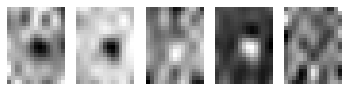

In [10]:
def znorm(data):
    """
    Normalizing raw trace.
    """
    return (data - data.mean())/data.std()

def interpolate_weights(tracetime, traces_znorm, triggers):
    
    """
    Align the stimulus time and triggertime, 
    aka downsampling the raw trace to the same length as the stimulus.
    """
    
    from scipy import interpolate
    data_interp = interpolate.interp1d(
        tracetime.flatten(), 
        traces_znorm.flatten(),
        kind = 'linear'
    ) (triggers)
    
    return znorm(data_interp)

import numpy as np
import matplotlib.pyplot as plt
import h5py
from rfest import splineLG, build_design_matrix

stim = h5py.File('../data/raw/noise.h5', 'r')['k'][:].T

traces_raw = rois.data_rawtraces.loc[0]['Traces0_raw_noise']
tracetime = rois.data_rawtraces.loc[0]['Tracetimes0_noise']
triggertime = rois.data_rawtraces.loc[0]['Triggertimes_noise']

dims = [5, 20, 15]

y = interpolate_weights(tracetime, znorm(traces_raw), triggertime)
y = np.gradient(y)

X = build_design_matrix(stim, dims[0])

spl = splineLG(X, y, dims=dims, df=7)

fig, ax = plt.subplots(1,dims[0])
for i in range(dims[0]):
    ax[i].imshow(spl.w_spl.reshape(dims)[i], cmap=plt.cm.binary)
    ax[i].axis('off')

## Computing pairwise overlap of RF contour

Method `compute_pairwise` is for computing contours overlap.

## Plot

Plot all ROIs onto morphology.

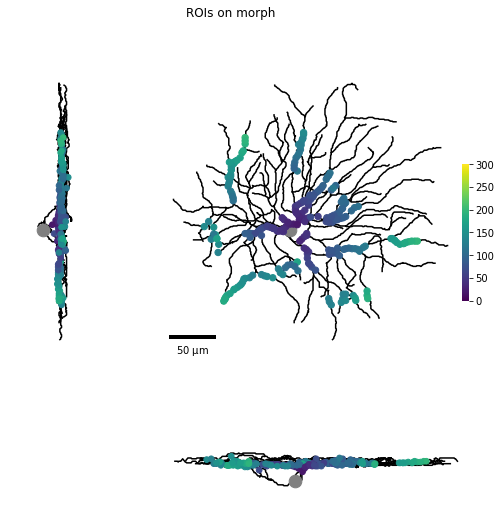

In [11]:
rois.plot_rois()

Plot all RF contours onto morphology.

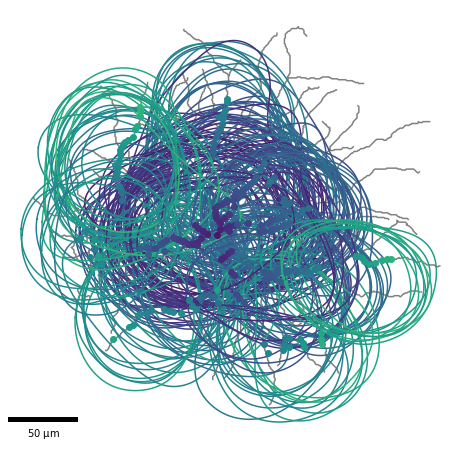

In [12]:
rois.plot_cntr()